In [1]:
import torch
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomGeoSampler
import matplotlib.pyplot as plt
import numpy as np
from torchgeo.datasets.utils import stack_samples
from datasets import load_dataset
import rasterio as rs
import cv2
import random
from pathlib import Path

c:\Users\KenzoBounegta\SegSat\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
S2_path = Path(r'C:\Users\KenzoBounegta\SegSat\dataset\sen1floods11_v1.1\sen1floods11_v1.1\data\S2L1CHand\USA_1010394_S2Hand.tif')

In [4]:
mask_path = Path(str(S2_path).replace('S2L1CHand', 'LabelHand').replace("S2Hand", 'LabelHand'))
mask_path

WindowsPath('C:/Users/KenzoBounegta/SegSat/dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/LabelHand/USA_1010394_LabelHand.tif')

In [5]:
with open(S2_path, 'rb') as file:
    sample = rs.open(file)

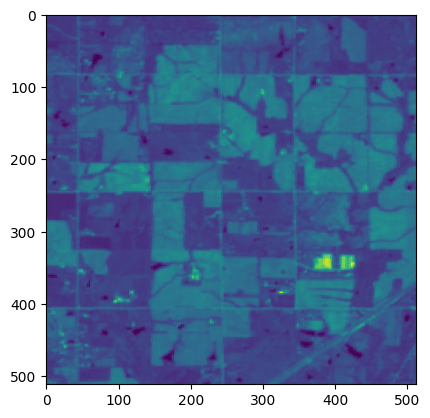

In [6]:
plt.imshow(sample.read(13))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4217557251908397..7.344329896907216].


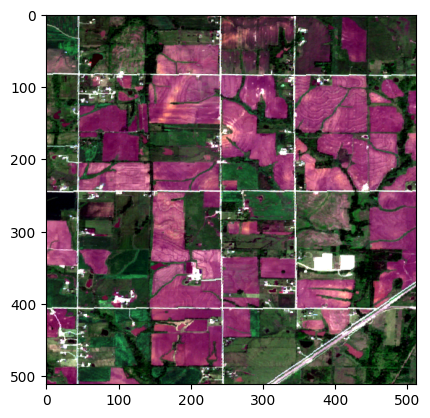

In [7]:
red = sample.read(4)
green = sample.read(3)
blue = sample.read(2)
rgb = np.stack((red, green, blue))
min_rgb, max_rgb = np.percentile(rgb, (2, 98), axis=(1, 2), keepdims=True)
normalized_rgb = (rgb - min_rgb) / (max_rgb - min_rgb)
plt.imshow(normalized_rgb.transpose(1,2,0))

ndvi = (sample.read(8) - sample.read(4)) / (sample.read(8) + sample.read(4))
nwdi = (sample.read(8) - sample.read(11)) / (sample.read(8) + sample.read(11))

In [8]:
with open(mask_path, 'rb') as file:
    mask = rs.open(file)

# C:\Users\KenzoBounegta\SegSat\dataset\sen1floods11_v1.1\sen1floods11_v1.1\data\S2L1CHand\USA_1039203_S2Hand.tif
# C:\Users\KenzoBounegta\SegSat\dataset\sen1floods11_v1.1\sen1floods11_v1.1\data\LabelHand\._Bolivia_242570_LabelHand.tif

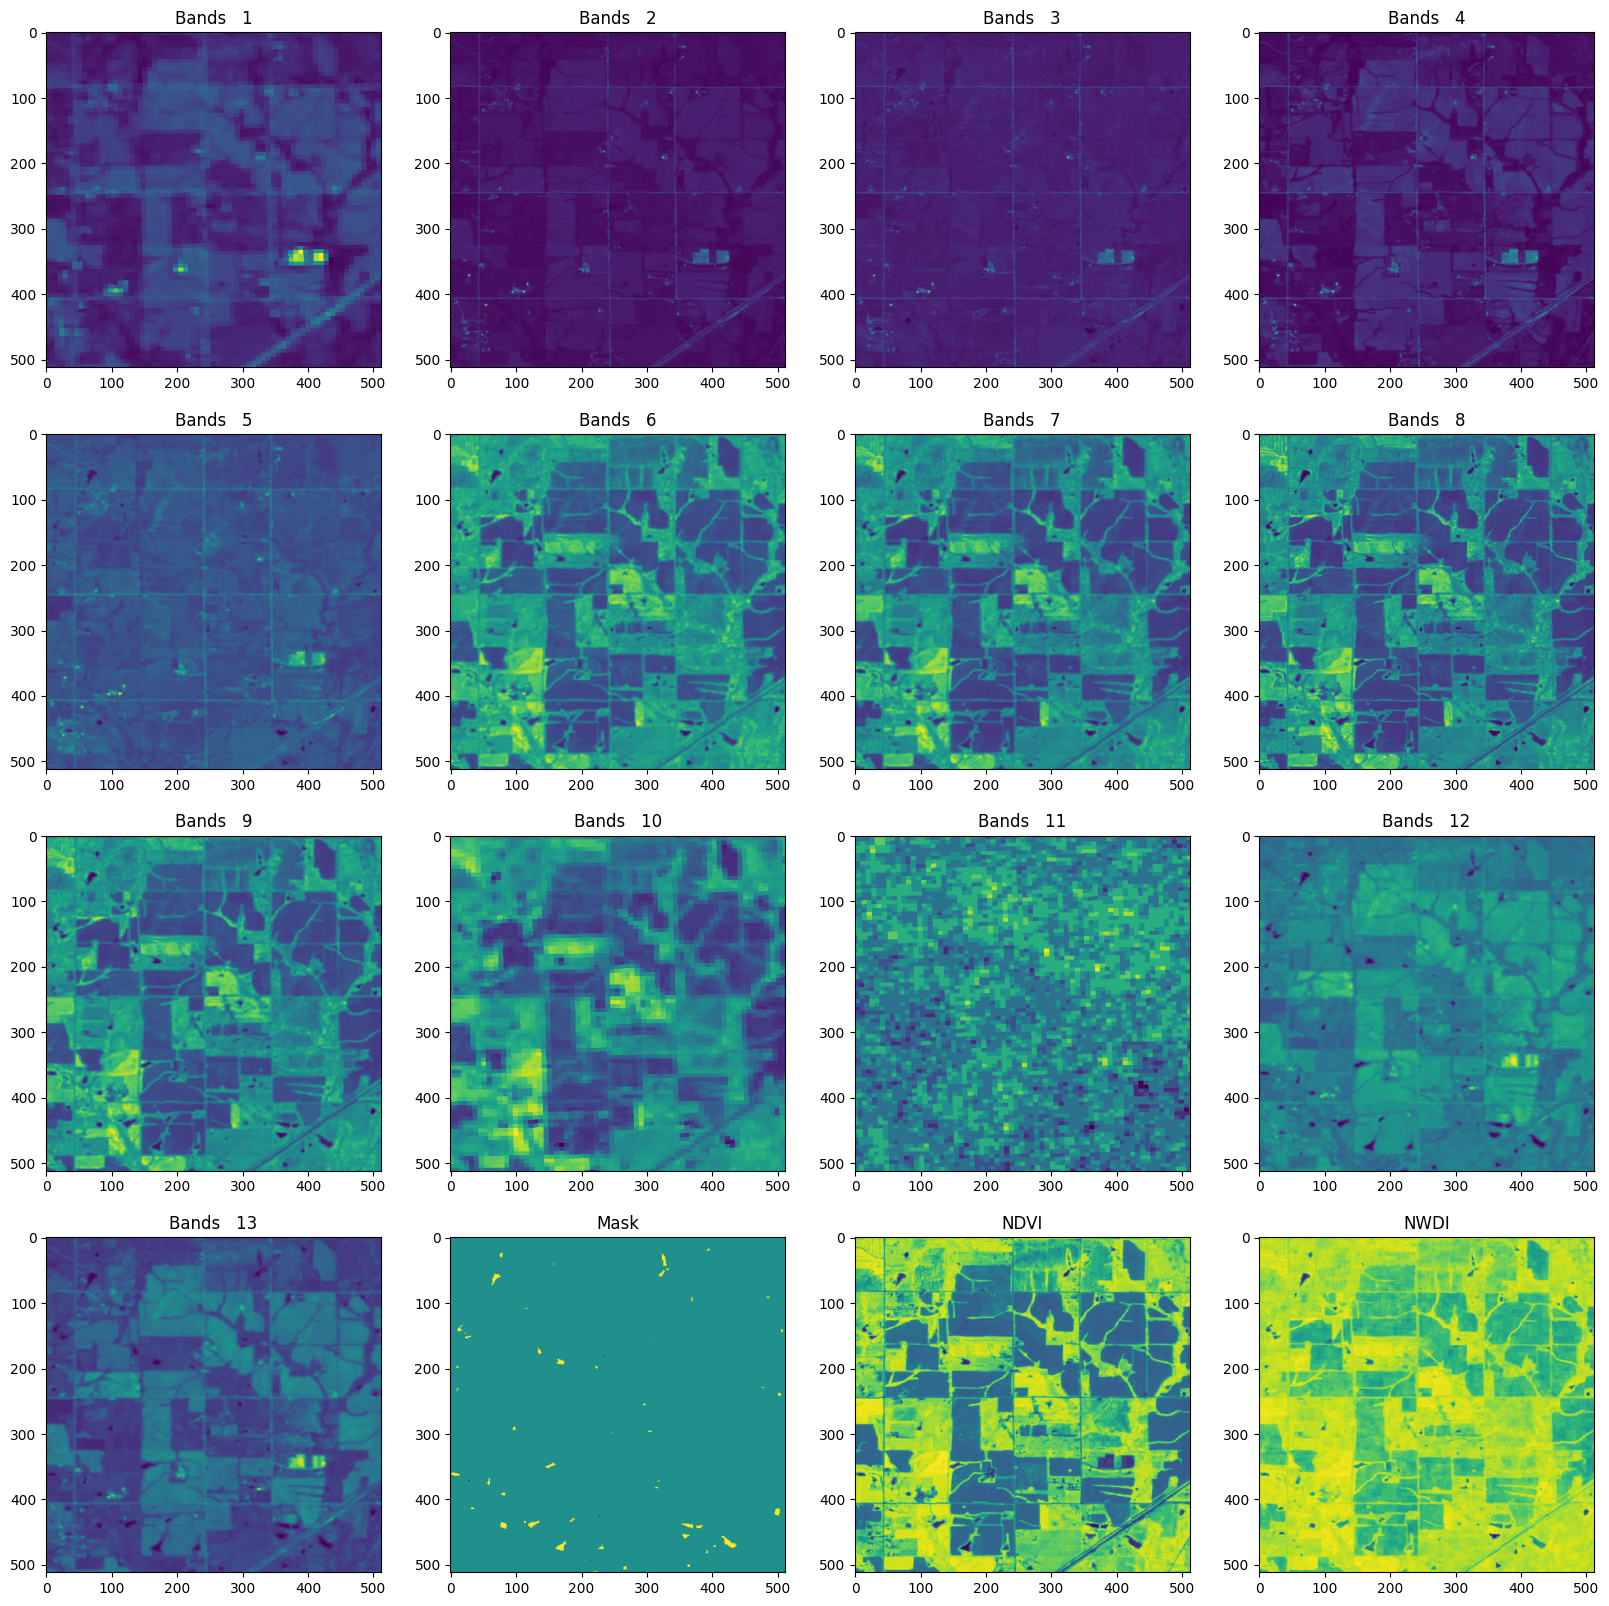

In [9]:
plt.figure(figsize=(20,20))
for k in range(1,14):
    plt.subplot(4,4,k)
    plt.title(f"Bands   {k}")
    plt.imshow(sample.read(k))

plt.subplot(4,4,14)
plt.imshow(mask.read(1))
plt.title('Mask')

plt.subplot(4,4,15)
plt.imshow(ndvi)
plt.title('NDVI')


plt.subplot(4,4,16)
plt.imshow(nwdi)
plt.title('NWDI')
plt.show()

In [10]:
band_1 = sample.read(1)
band_1 == mask.read(1)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(512, 512))

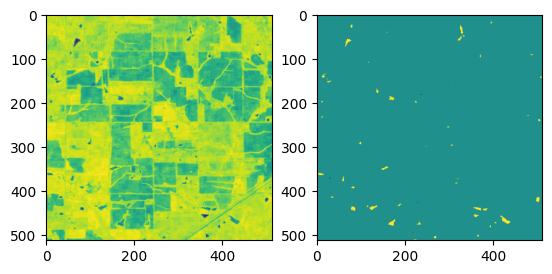

In [11]:
plt.subplot(1,2,1)
plt.imshow(nwdi)
plt.subplot(1,2,2)
plt.imshow(mask.read(1))

Text(0.5, 1.0, 'Band analysis for /vsimem/43ff113b-d619-4b67-bd9b-3173cc383865/43ff113b-d619-4b67-bd9b-3173cc383865.tif')

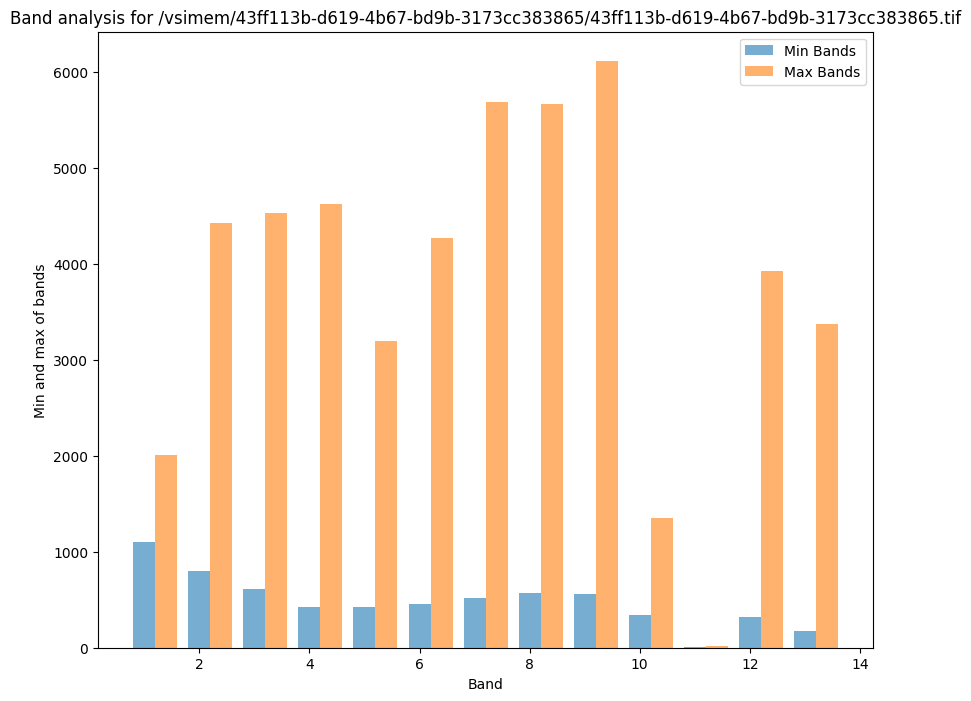

In [12]:
min_bands = []
max_bands = []
x_axis = range(1,14)
for k in x_axis:
    band = sample.read(int(k))

    min_bands.append(band.min())
    max_bands.append(band.max())

plt.figure(figsize=(10,8))
# We will make a bar plot of the min and max values of each band
plt.bar(x_axis, min_bands, width=0.4, label='Min Bands', alpha=0.6)
plt.bar([x + 0.4 for x in x_axis], max_bands, width=0.4, label='Max Bands', alpha=0.6)

plt.xlabel('Band')
plt.ylabel('Min and max of bands')
plt.legend()
plt.title(f'Band analysis for {str(sample.name)}')


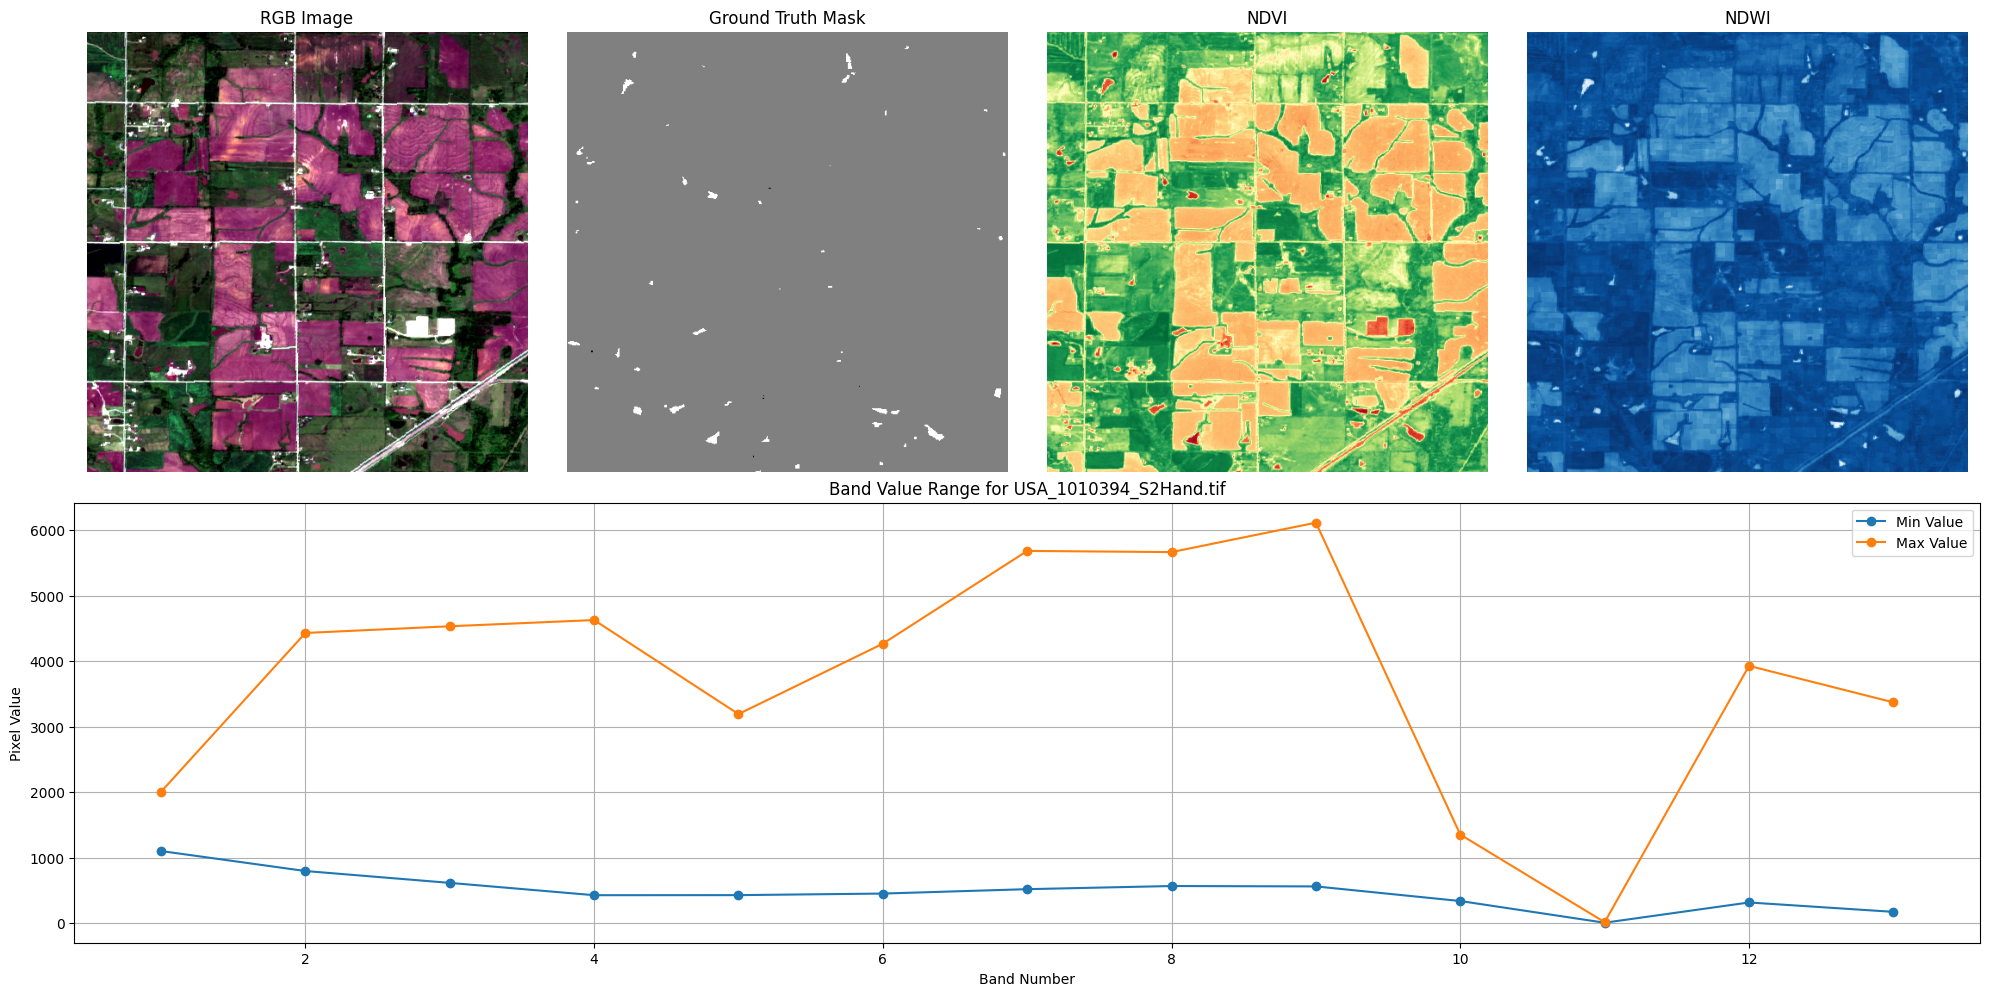

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rs
from pathlib import Path

# --- Configuration ---
S2_path = Path(r'C:\Users\KenzoBounegta\SegSat\dataset\sen1floods11_v1.1\sen1floods11_v1.1\data\S2L1CHand\USA_1010394_S2Hand.tif')
mask_path = Path(str(S2_path).replace('S2L1CHand', 'LabelHand').replace('S2Hand', 'LabelHand')) # Remplacement plus robuste

# --- Chargement des données (de manière efficace et correcte) ---
with rs.open(S2_path) as sample_src:
    # Lis toutes les bandes de l'image S2 en une seule fois
    s2_bands = sample_src.read() 
    
with rs.open(mask_path) as mask_src:
    # Lis la seule bande du masque
    mask_data = mask_src.read(1)

# --- Analyse et Visualisation ---

# 1. Image RGB
red = s2_bands[3] # Bande 4
green = s2_bands[2] # Bande 3
blue = s2_bands[1] # Bande 2
rgb = np.stack((red, green, blue))

# Normalisation pour la visualisation
min_val, max_val = np.percentile(rgb, (2, 98), axis=(1, 2), keepdims=True)
normalized_rgb = (rgb - min_val) / (max_val - min_val + 1e-8) # +epsilon pour éviter division par zéro
normalized_rgb = np.clip(normalized_rgb, 0, 1) # Assurer que les valeurs sont dans [0, 1]

# 2. Indices
nir = s2_bands[7].astype(np.float32) # Bande 8
red = s2_bands[3].astype(np.float32) # Bande 4
swir1 = s2_bands[10].astype(np.float32) # Bande 11
epsilon = 1e-8

ndvi = (nir - red) / (nir + red + epsilon)
nwdi = (nir - swir1) / (nir + swir1 + epsilon)

# 3. Figure de synthèse
plt.figure(figsize=(20, 10))

# Image RGB
plt.subplot(2, 4, 1)
plt.imshow(normalized_rgb.transpose(1, 2, 0))
plt.title('RGB Image')
plt.axis('off')

# Masque
plt.subplot(2, 4, 2)
plt.imshow(mask_data, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

# NDVI
plt.subplot(2, 4, 3)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI')
plt.axis('off')

# NWDI
plt.subplot(2, 4, 4)
plt.imshow(nwdi, cmap='Blues')
plt.title('NDWI')
plt.axis('off')

# 4. Analyse des valeurs min/max par bande
x_axis = range(1, s2_bands.shape[0] + 1)
min_vals = [band.min() for band in s2_bands]
max_vals = [band.max() for band in s2_bands]

ax2 = plt.subplot(2, 1, 2) # Place ce graphe sous les images
ax2.plot(x_axis, min_vals, label='Min Value', marker='o')
ax2.plot(x_axis, max_vals, label='Max Value', marker='o')
ax2.set_xlabel('Band Number')
ax2.set_ylabel('Pixel Value')
ax2.set_title(f'Band Value Range for {S2_path.name}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
S2_folder_path = Path(r"C:..\dataset\sen1floods11_v1.1\sen1floods11_v1.1\data\S2L1CHand")

In [15]:
image_list = [f for f in S2_folder_path.glob('*.tif') if not f.name.startswith("._")]

In [16]:
image_list

[WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_103757_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_129334_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_195474_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_23014_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_233925_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_242570_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_290290_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_294583_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods11_v1.1/sen1floods11_v1.1/data/S2L1CHand/Bolivia_312675_S2Hand.tif'),
 WindowsPath('C:../dataset/sen1floods1

In [17]:
def extract_mean_and_std(image_path):
    with rs.open(image_path) as sample:
        bands = sample.read()
    mean = [np.mean(band) for band in bands]
    std = [np.std(band) for band in bands]
    return mean, std

In [18]:
all_means = []
all_stds = []
for image_path in image_list:
    mean, std = extract_mean_and_std(image_path)
    all_means.append(mean)
    all_stds.append(std)

mean_of_all_bands = [np.mean(band) for band in zip(*all_means)]
std_of_all_bands = [np.mean(band) for band in zip(*all_stds)]

In [19]:
mean_of_all_bands, std_of_all_bands

([np.float64(1612.2641794179053),
  np.float64(1379.8899556061613),
  np.float64(1344.4295633683826),
  np.float64(1195.157229000143),
  np.float64(1439.168369746529),
  np.float64(2344.2498120705645),
  np.float64(2796.473722876989),
  np.float64(2578.4108992777597),
  np.float64(3023.817505678254),
  np.float64(476.7287418382585),
  np.float64(59.24111403905757),
  np.float64(1989.1945548720423),
  np.float64(1152.4886461779677)],
 [np.float64(364.9812301923595),
  np.float64(413.82623556557127),
  np.float64(427.52051215738015),
  np.float64(524.9453369491698),
  np.float64(475.69782785743575),
  np.float64(647.7953882510243),
  np.float64(777.0362579230544),
  np.float64(748.5137636766178),
  np.float64(859.4795267139729),
  np.float64(148.47238356168697),
  np.float64(17.722249334104454),
  np.float64(699.5845557688306),
  np.float64(529.9042679480442)])

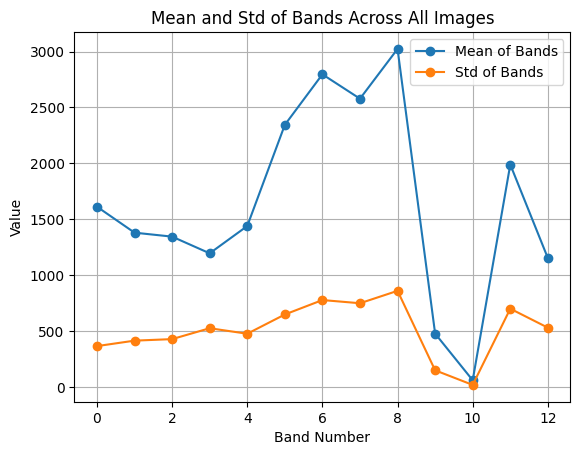

In [20]:
plt.plot(mean_of_all_bands, label='Mean of Bands', marker='o')
plt.plot(std_of_all_bands, label='Std of Bands', marker='o')
plt.xlabel('Band Number')
plt.ylabel('Value')
plt.title('Mean and Std of Bands Across All Images')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# we will calculate the mean and std of the train dataset
def calculate_mean_std(dataset):
    means = []
    stds = []
    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]
        means.append(torch.mean(image_tensor, dim=(1,2)))
        stds.append(torch.std(image_tensor, dim=(1,2)))
    return torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)

def debug(dataset):
    means = []
    stds = []
    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]
        means.append(image_tensor.mean(dim=(1,2)))
        stds.append(image_tensor.std(dim=(1,2)))
    return means, std


True
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.144605110549713..1.3476164989890669].


Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15978835711965614..1.8290648601270463].


Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050164213598870605..1.7482830355529784].


Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07070020176392455..1.654069853445954].


Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6395349759166552..6.520270055441683].


Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)


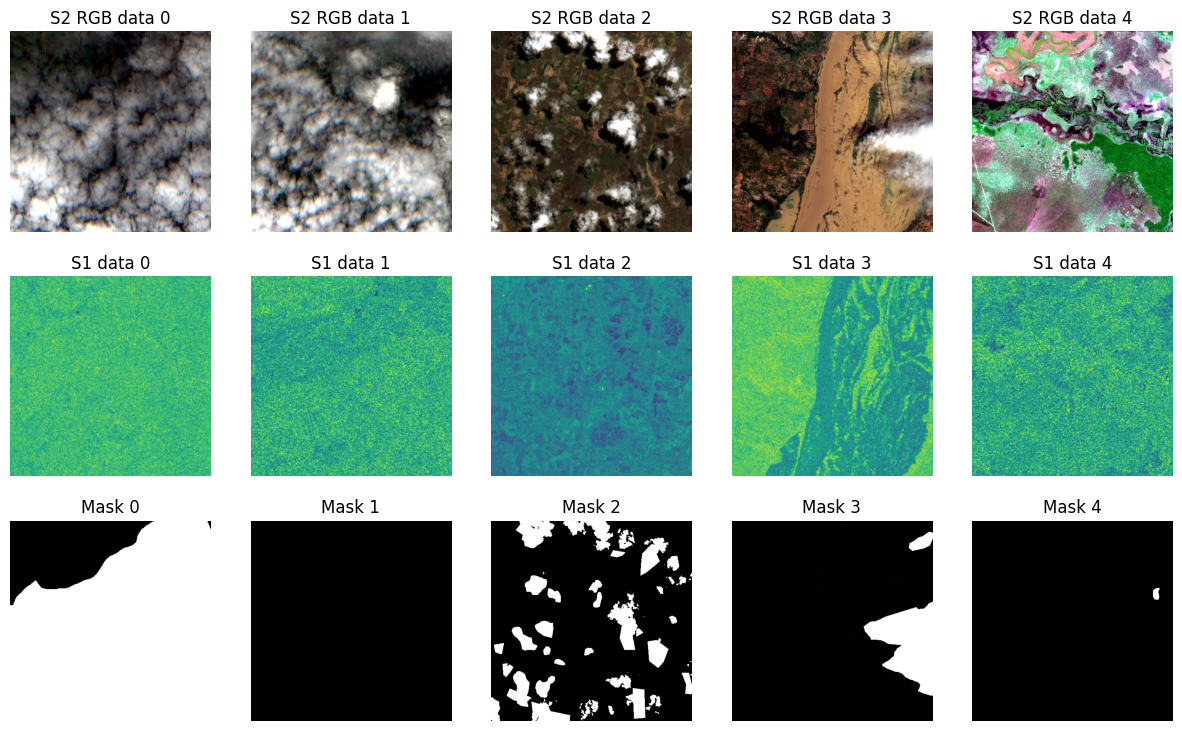

In [34]:
import dataset
import config

val_dataset = dataset.Sen1FloodsDataset(
    root_dir= config.ROOT_DIR,
    bands = config.S2_BANDS_TO_USE,
    modalities = config.MODALITIES,
    split='train'
)

plt.figure(figsize=(15,9))
for k in range(5):
    plt.subplot(3, 5, k + 1)
    bands = val_dataset[k][0]
    red = bands[2]
    green = bands[1]
    blue = bands[0]
    rgb = np.stack((red, green, blue))
    min_rgb, max_rgb = np.percentile(rgb, (2, 98), axis=(1, 2), keepdims=True)
    normalized_rgb = (rgb - min_rgb) / (max_rgb - min_rgb)
    plt.title(f"S2 RGB data {k}")
    plt.axis('off')
    plt.imshow(normalized_rgb.transpose(1,2,0))
    plt.subplot(3, 5, k + 6)
    plt.title(f"S1 data {k}")
    plt.axis('off')
    plt.imshow(val_dataset[k][0][-2])
    plt.subplot(3, 5, k + 11)
    plt.title(f"Mask {k}")
    plt.axis('off')
    plt.imshow(val_dataset[k][1].permute(1,2,0), cmap='gray')


In [23]:
import eval

test_performance = eval.test_model(
    model=eval.U_NET_MODEL,
    test_loader=eval.test_dataloader,
    save_predictions=True,
    criterion=eval.criterion,
)

True
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S2 image with bands (2, 3, 4, 5, 6, 7, 8, 11, 12)
Reading S

In [24]:
outputs, masks = test_performance[2]

In [25]:
masks[0][0].shape

torch.Size([512, 512])

In [26]:
outputs[0][0].shape

torch.Size([512, 512])

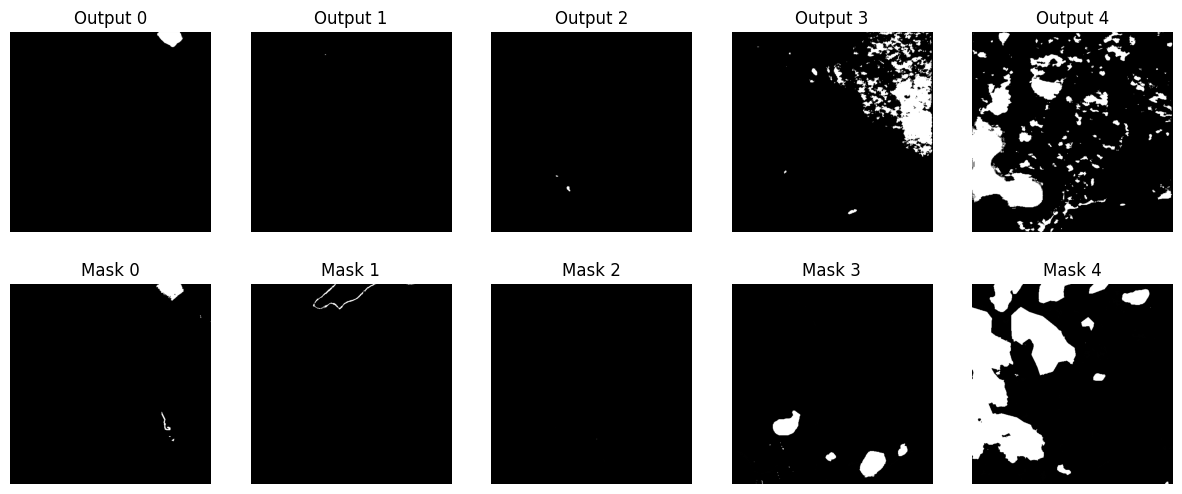

In [27]:
plt.figure(figsize=(15,6))
for k in range(5):
    plt.subplot(2, 5, k + 1)
    plt.title(f"Output {k}")
    plt.axis('off')
    plt.imshow(outputs[0][k+3].numpy(), cmap='gray')
    plt.subplot(2, 5, k + 6)
    plt.title(f"Mask {k}")
    plt.axis('off')
    plt.imshow(masks[0][k+3].numpy(), cmap='gray')
